In [1]:
# train a classical generative adversarial network on a gaussian probability distribution
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Dropout, Reshape, LeakyReLU, Flatten, BatchNormalization
from matplotlib import pyplot

In [4]:
# define the standalone discriminator model
def define_discriminator(n_inputs=1, alpha=0.2, dropout=0.2):
    model = Sequential()
        
    model.add(Dense(200, use_bias=False, input_dim=n_inputs))
    model.add(Reshape((50,2,2)))
    
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(8, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))

    model.add(Flatten())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout)) 

    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=1, alpha=0.2):
    model = Sequential()

    model.add(Dense(125, input_dim=latent_dim, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Reshape((25,5,1)))

    model.add(Conv2DTranspose(32, kernel_size=2, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2DTranspose(16, kernel_size=2, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2DTranspose(8, kernel_size=3, strides=1, padding=('same'), use_bias=False, kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=alpha))

    model.add(Flatten())

    model.add(Dense(n_outputs, activation='tanh'))
    
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# generate real samples with class labels
def generate_real_samples(samples, sigma=0.25, mu=0.0):
    # generate samples from the distribution
    s = np.random.normal(mu, sigma, samples)
    # shape array
    X = s.reshape(samples, 1)
    # generate class labels
    y = np.ones((samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, samples):
    # generate points in the latent space
    x_input = randn(latent_dim * samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(samples, latent_dim)
    return x_input
 
# use the generator to generate fake examples, with class labels
def generate_fake_samples(generator, latent_dim, samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, samples)
    # predict outputs
    X = generator.predict(x_input)
    # shape array
    X = X.reshape(samples, 1)
    # create class labels
    y = np.zeros((samples, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake samples
def summarize_performance(epoch, generator, discriminator, latent_dim, samples, nbins):
    # prepare real samples
    x_real, y_real = generate_real_samples(100000)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, 100000)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('epoch: ',epoch, 'acc_real: ', acc_real, 'acc_fake: ', acc_fake)
    # histogram plot real and fake data points
    pyplot.hist(x_real, np.linspace(-1.0, 1.0, nbins+1), color='red', label='real', alpha=0.5)
    pyplot.hist(x_fake, np.linspace(-1.0, 1.0, nbins+1), color='blue', label='fake', alpha=0.5)
    #yplot.hist(x_real, color='red', label='real', alpha=0.5)
    #yplot.hist(x_fake, color='blue', label='fake', alpha=0.5)
    pyplot.legend()
    pyplot.show()
    

    # serialize weights to HDF5
    generator.save_weights(str(epoch)+"_generator.h5")
    print("Saved generator to disk")
    discriminator.save_weights(str(epoch)+"_discriminator.h5")
    print("Saved discriminator to disk")
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, samples=256, nbins=49, n_eval=250):
    # determine half the size of one batch, for updating the discriminator
    half_samples = int(samples / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_samples)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_samples)
        # update discriminator
        d_model.trainable = True
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, samples)
        # create inverted labels for the fake samples
        y_gan = np.ones((samples, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim, samples, nbins)

epoch:  249 acc_real:  0.9934399724006653 acc_fake:  1.0


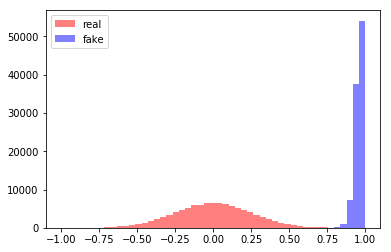

Saved generator to disk
Saved discriminator to disk
epoch:  499 acc_real:  0.8131700158119202 acc_fake:  0.6862900257110596


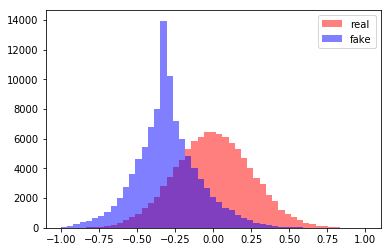

Saved generator to disk
Saved discriminator to disk
epoch:  749 acc_real:  0.8531100153923035 acc_fake:  0.5549100041389465


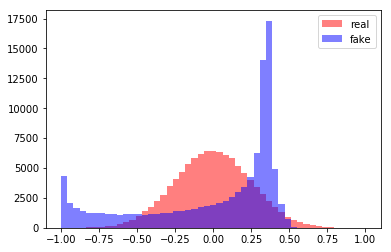

Saved generator to disk
Saved discriminator to disk
epoch:  999 acc_real:  0.5357300043106079 acc_fake:  0.7418500185012817


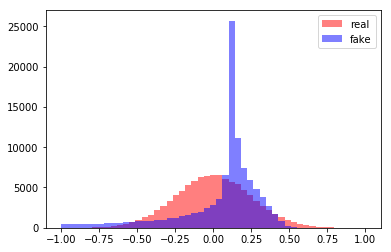

Saved generator to disk
Saved discriminator to disk
epoch:  1249 acc_real:  0.7919399738311768 acc_fake:  0.2055799961090088


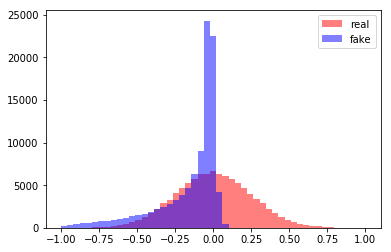

Saved generator to disk
Saved discriminator to disk
epoch:  1499 acc_real:  0.42704999446868896 acc_fake:  0.4949699938297272


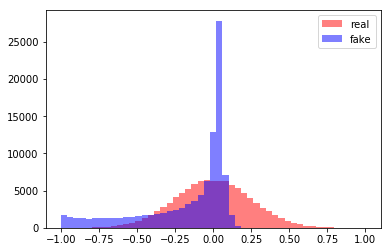

Saved generator to disk
Saved discriminator to disk
epoch:  1749 acc_real:  0.4060400128364563 acc_fake:  0.388700008392334


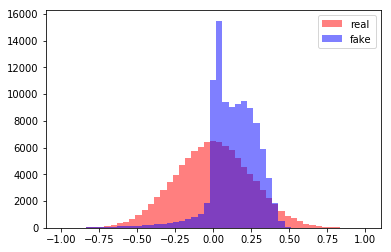

Saved generator to disk
Saved discriminator to disk
epoch:  1999 acc_real:  0.5365599989891052 acc_fake:  0.3146199882030487


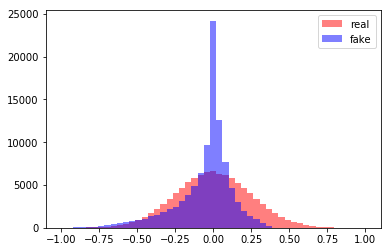

Saved generator to disk
Saved discriminator to disk
epoch:  2249 acc_real:  0.3169800043106079 acc_fake:  0.5790600180625916


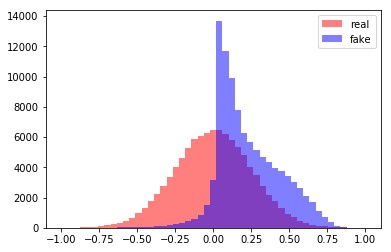

Saved generator to disk
Saved discriminator to disk
epoch:  2499 acc_real:  0.9855899810791016 acc_fake:  0.002959999954327941


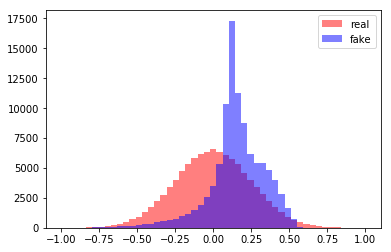

Saved generator to disk
Saved discriminator to disk
epoch:  2749 acc_real:  0.9814299941062927 acc_fake:  0.021959999576210976


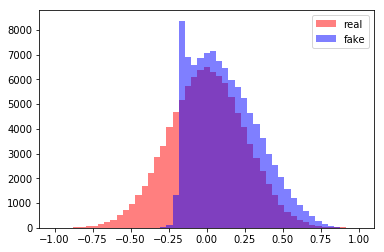

Saved generator to disk
Saved discriminator to disk
epoch:  2999 acc_real:  0.5685700178146362 acc_fake:  0.581529974937439


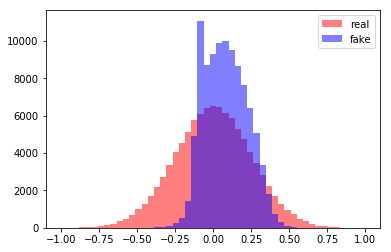

Saved generator to disk
Saved discriminator to disk
epoch:  3249 acc_real:  0.5393499732017517 acc_fake:  0.9119600057601929


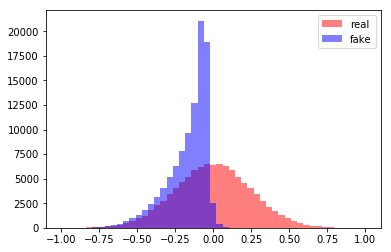

Saved generator to disk
Saved discriminator to disk
epoch:  3499 acc_real:  0.9768199920654297 acc_fake:  0.024650000035762787


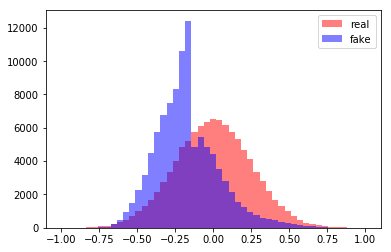

Saved generator to disk
Saved discriminator to disk
epoch:  3749 acc_real:  0.9827899932861328 acc_fake:  0.027879999950528145


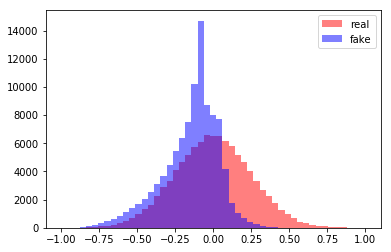

Saved generator to disk
Saved discriminator to disk
epoch:  3999 acc_real:  0.4033699929714203 acc_fake:  0.9253000020980835


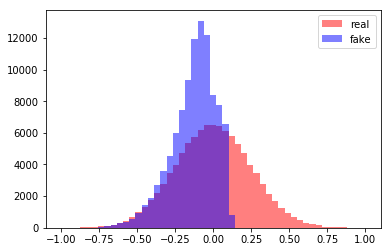

Saved generator to disk
Saved discriminator to disk
epoch:  4249 acc_real:  0.9269599914550781 acc_fake:  0.03002999909222126


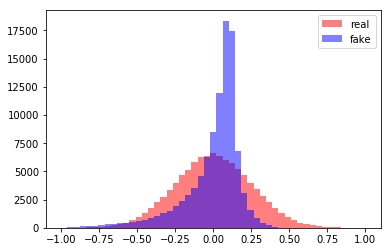

Saved generator to disk
Saved discriminator to disk
epoch:  4499 acc_real:  0.7514700293540955 acc_fake:  0.4124099910259247


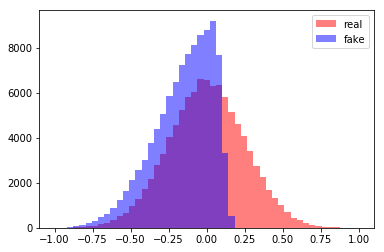

Saved generator to disk
Saved discriminator to disk
epoch:  4749 acc_real:  0.5714799761772156 acc_fake:  0.5742899775505066


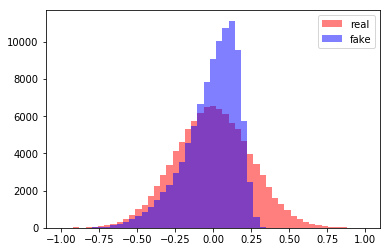

Saved generator to disk
Saved discriminator to disk
epoch:  4999 acc_real:  0.4351600110530853 acc_fake:  0.5124899744987488


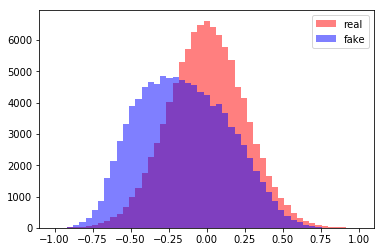

Saved generator to disk
Saved discriminator to disk
epoch:  5249 acc_real:  0.45541998744010925 acc_fake:  0.8360400199890137


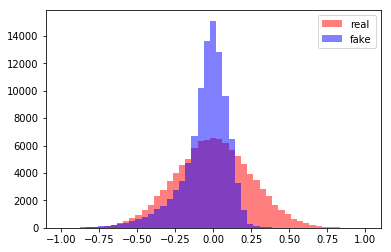

Saved generator to disk
Saved discriminator to disk
epoch:  5499 acc_real:  0.7084599733352661 acc_fake:  0.26857998967170715


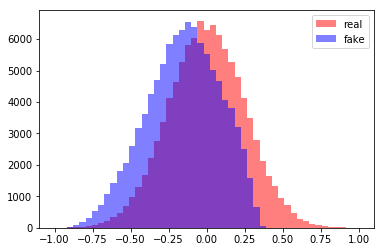

Saved generator to disk
Saved discriminator to disk
epoch:  5749 acc_real:  0.5676000118255615 acc_fake:  0.5789499878883362


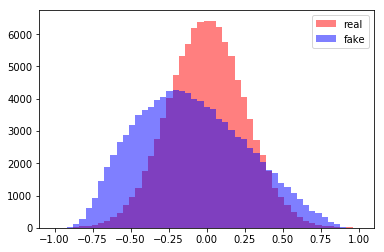

Saved generator to disk
Saved discriminator to disk
epoch:  5999 acc_real:  0.4777100086212158 acc_fake:  0.6595900058746338


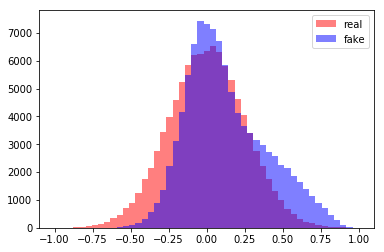

Saved generator to disk
Saved discriminator to disk
epoch:  6249 acc_real:  0.783240020275116 acc_fake:  0.5857700109481812


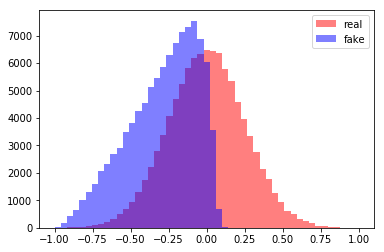

Saved generator to disk
Saved discriminator to disk
epoch:  6499 acc_real:  0.7152699828147888 acc_fake:  0.5125300288200378


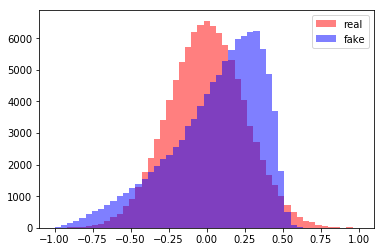

Saved generator to disk
Saved discriminator to disk
epoch:  6749 acc_real:  0.7348999977111816 acc_fake:  0.25047001242637634


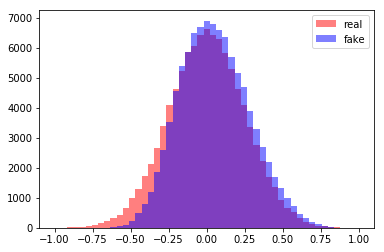

Saved generator to disk
Saved discriminator to disk
epoch:  6999 acc_real:  0.3428100049495697 acc_fake:  0.9644399881362915


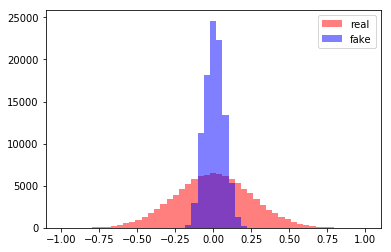

Saved generator to disk
Saved discriminator to disk


In [3]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# serialize generator and discriminator to JSON
gen_model_json = generator.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(gen_model_json)
disc_model_json = discriminator.to_json()
with open("discriminator.json", "w") as json_file:
    json_file.write(disc_model_json)
# train model
train(generator, discriminator, gan_model, latent_dim)

Loaded model from disk


(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        5.0000e+00, 1.2000e+01, 1.6000e+01, 1.8000e+01, 4.3000e+01,
        7.8000e+01, 1.5300e+02, 2.0900e+02, 3.1100e+02, 4.3200e+02,
        6.7900e+02, 8.3600e+02, 1.1630e+03, 1.5550e+03, 2.0150e+03,
        2.5500e+03, 3.1020e+03, 3.8720e+03, 4.7440e+03, 5.5630e+03,
        6.5230e+03, 7.6590e+03, 8.9230e+03, 1.0156e+04, 1.1219e+04,
        1.2231e+04, 1.3176e+04, 1.4075e+04, 1.4812e+04, 1.5656e+04,
        1.6093e+04, 1.6605e+04, 1.6690e+04, 1.7049e+04, 1.7065e+04,
        1.7202e+04, 1.7145e+04, 1.6717e+04, 1.6474e+04, 1.6043e+04,
        1.5494e+04, 1.4935e+04, 1.4372e+04, 1.3429e+04, 1.2752e+04,
        1.2217e+04, 1.1289e+04, 1.0573e+04, 9.8530e+03, 9.0080e+03,
        8.1650e+03, 7.5140e+03, 6.9940e+03, 6.1930e+03, 5.4590e+03,
        5.0130e+03, 4.3100e+03, 3.7590e+03, 3.34

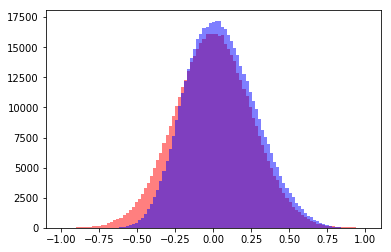

In [7]:
# load json and create model
json_file = open('generator.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("6749_generator.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
x_real, y_real = generate_real_samples(samples=500000)
x_fake, y_fake = generate_fake_samples(loaded_model, latent_dim, samples=500000)
pyplot.hist(x_real, np.linspace(-1.0, 1.0, 100), color='red', label='real', alpha=0.5)
pyplot.hist(x_fake, np.linspace(-1.0, 1.0, 100), color='blue', label='fake', alpha=0.5)